# Catalog-based forecast tutorial - UCERF3 Landers

In this tutorial we will look at an example of a catalog-based forecast.  

Our goal is to test whether the forecast number of earthquakes from a UCERF3-ETAS aftershock model is consistent with observations for the 1992 Landers sequence.
The PyCSEP package has been designed so that the order of the steps that we take to do this is very similar to that for the gridded forecasts with a few differences. This tutorial aims to familiarise the user with some of the differences involved and further understanding of how these new CSEP tests are carried out.

Full documentation of the package can be found [here](https://docs.cseptesting.org/) and any issues can be reported on the [PyCSEP Github page](https://github.com/SCECcode/pycsep).

In [13]:
import numpy

# Most of the core functionality can be imported from the top-level csep package. 
# Utilities are available from the csep.utils subpackage.
import csep
from csep.core import regions, catalog_evaluations
from csep.core import poisson_evaluations as poisson
from csep.utils import datasets, time_utils, comcat, plots

## 1. Load forecast

Forecasts should define a time horizon in which they are valid. The choice is flexible for catalog-based forecasts, because the catalogs can be filtered to accommodate multiple end-times. Conceptually, these should be separate forecasts.  

For catalog-based forecasts, we need to explicitly compute bin-wise rates. Before we can compute the bin-wise rates we need to define a spatial region and a set of magnitude bin edges. The magnitude bin edges # are the lower bound (inclusive) except for the last bin, which is treated as extending to infinity. We can bind these # to the forecast object.  

The spatial region should also be explicitly defined, in contrast to the gridded forecast where this is extracted from the data. In this example, we use the RELM polygon included in the package. This can also be done by passing the region as keyword arguments into `csep.load_catalog_forecast()`.


In [2]:
### Set up model parameters
# Start and end time
start_time = time_utils.strptime_to_utc_datetime("1992-06-28 11:57:34.14")
end_time = time_utils.strptime_to_utc_datetime("1992-07-28 11:57:34.14")

# Magnitude bins properties
min_mw = 4.95
max_mw = 8.95
dmw = 0.1

# Create space and magnitude regions. The forecast is already filtered in space and magnitude
magnitudes = regions.magnitude_bins(min_mw, max_mw, dmw)
region = regions.california_relm_region()

# Bind region information to the forecast (this will be used for binning of the catalogs)

space_magnitude_region = regions.create_space_magnitude_region(region, magnitudes)


To reduce the file size of this example, we’ve already filtered the catalogs to the appropriate magnitudes and spatial locations. The original forecast was computed for 1 year following the start date, so we still need to filter the catalog in time. We can do this by passing a list of filtering arguments to the forecast or updating the class.

By default, the forecast loads catalogs on-demand, so the filters are applied as the catalog loads. On-demand means that until we loop over the forecast in some capacity, none of the catalogs are actually loaded.

More fine-grain control and optimizations can be achieved by creating a `csep.core.forecasts.CatalogForecast` directly.


In [3]:
forecast = csep.load_catalog_forecast(datasets.ucerf3_ascii_format_landers_fname,
                                      start_time = start_time, end_time = end_time,
                                      region = space_magnitude_region)

The `csep.core.forecasts.CatalogForecast` provides a method to compute the expected number of events in spatial cells. This requires a region with magnitude information.

In [5]:
# Assign filters to forecast (in this case time)
forecast.filters = [f'origin_time >= {forecast.start_epoch}', f'origin_time < {forecast.end_epoch}']
_ = forecast.get_expected_rates(verbose=True)

Processed 1 catalogs in 0.00936126708984375 seconds
Processed 2 catalogs in 0.015309333801269531 seconds
Processed 3 catalogs in 0.02156352996826172 seconds
Processed 4 catalogs in 0.025475502014160156 seconds
Processed 5 catalogs in 0.02987074851989746 seconds
Processed 6 catalogs in 0.03422117233276367 seconds
Processed 7 catalogs in 0.03781580924987793 seconds
Processed 8 catalogs in 0.041291236877441406 seconds
Processed 9 catalogs in 0.0470736026763916 seconds
Processed 10 catalogs in 0.053049564361572266 seconds
Processed 20 catalogs in 0.08385181427001953 seconds
Processed 30 catalogs in 0.10664606094360352 seconds
Processed 40 catalogs in 0.13093161582946777 seconds
Processed 50 catalogs in 0.15259289741516113 seconds
Processed 60 catalogs in 0.17044758796691895 seconds
Processed 70 catalogs in 0.18909406661987305 seconds
Processed 80 catalogs in 0.20635581016540527 seconds
Processed 90 catalogs in 0.2249159812927246 seconds
Processed 100 catalogs in 0.24102306365966797 seconds

The expected rates can now be plotted in a similar manner to the gridded forecast plots. Again, we can specify plot arguments as we did for the gridded forecasts.

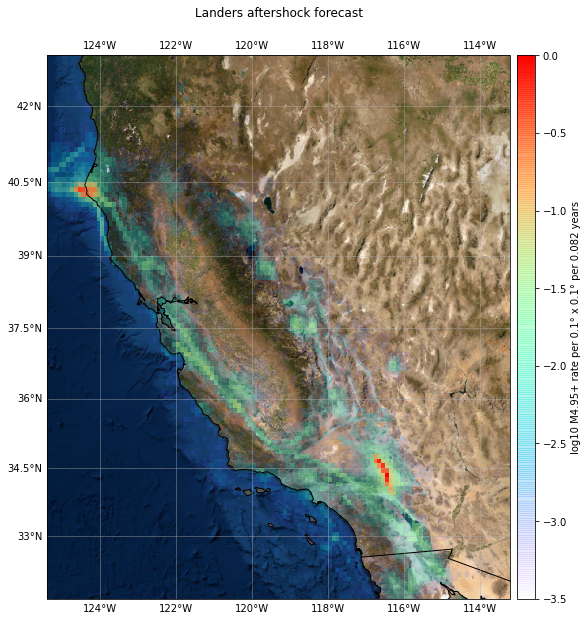

In [14]:
dict_arg = {'title': 'Landers aftershock forecast',
             'grid_labels': True,
             'borders': True,
             'feature_lw': 0.5,
             'basemap': 'ESRI_imagery',
             'cmap': 'rainbow',
             'alpha_exp': 0.9,
             'projection': cartopy.crs.Mercator(),
             'clim':[-3.5, 0]}

ax = forecast.expected_rates.plot(plot_args= dict_arg)

## 2.Filter evaluation catalog

In this example we use the `csep.query_comcat` function to obtain a catalog directly from [ComCat](https://earthquake.usgs.gov/data/comcat/). We need to filter the ComCat catalog to be consistent with the forecast. This can be done either through the ComCat API or using catalog filtering strings (see the gridded forecast example). Here we’ll use the Comcat API to make the data access quicker for this example. We still need to filter the observed catalog in space though.


In [7]:
# Obtain Comcat catalog and filter to region.
comcat_catalog = csep.query_comcat(start_time, end_time, min_magnitude=forecast.min_magnitude)

# Filter observed catalog using the same region as the forecast
comcat_catalog = comcat_catalog.filter_spatial(forecast.region)


Fetched ComCat catalog in 1.5132930278778076 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 1992-06-28 11:57:34.130000+00:00
End Date: 1992-07-24 18:14:36.250000+00:00
Min Latitude: 33.901 and Max Latitude: 36.698
Min Longitude: -118.067 and Max Longitude: -116.285
Min Magnitude: 4.95
Found 20 events in the ComCat catalog.


## 3. Perform a test 

Now that we have a forecast and evaluation catalog, tests can be easily applied in a similar way as with gridded forecasts. For example, we can perform the Number test on the catalog based forecast using the observed catalog we obtained from Comcat.

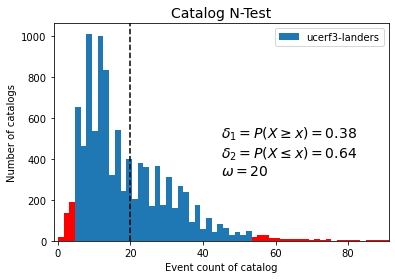

In [12]:
number_test_result = catalog_evaluations.number_test(forecast, comcat_catalog)
ax = number_test_result.plot()

### Questions for the reader

How should the above figure be interpreted? What does this test result tell you about the forecast?
How well does this model perform spatially?